## Install Packages

### To install a package, first open a new R-terminal in the terminal below (click the arrow next to plus and choose "R Terminal").

### Then install packages by copying and pasting the following commands in the terminal below and follow the instructions in the terminal.

In [2]:
install.packages('jsonlite')
install.packages('httr2')
install.packages('RColorBrewer')
devtools::install_github("wilkelab/cowplot")

Installing package into ‘/home/ubuntu/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Installing package into ‘/home/ubuntu/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

also installing the dependency ‘curl’


Warning message in install.packages("httr2"):
“installation of package ‘curl’ had non-zero exit status”
Installing package into ‘/home/ubuntu/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Skipping install of 'cowplot' from a github remote, the SHA1 (e1334a28) has not changed since last install.
  Use `force = TRUE` to force installation



### Then load the library by running the following code chunk

In [3]:
library(jsonlite);print(paste("jsonlite:",  packageVersion("jsonlite")))
library(httr2);print(paste("httr2:",  packageVersion("httr2")))
library(tidyverse);print(paste("tidyverse:",  packageVersion("tidyverse")))
library(ggplot2);print(paste("ggplot2:",  packageVersion("ggplot2")))
library(RColorBrewer);print(paste("RColorBrewer:",  packageVersion("RColorBrewer")))
library(cowplot, lib.loc = "/home/ubuntu/R/x86_64-pc-linux-gnu-library/4.3");print(paste("cowplot:",  packageVersion("cowplot")))

[1] "jsonlite: 1.8.8"
[1] "httr2: 1.0.0"


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "tidyverse: 2.0.0"
[1] "ggplot2: 3.5.0"
[1] "RColorBrewer: 1.1.3"



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




[1] "cowplot: 1.1.3.9000"


### Change global options to increase the "timeout" parameter. 

In [4]:
getOption('timeout')
options(timeout=300)
getOption('timeout')

[1] 60

[1] 300


## Get file from umwelt.info

Streaming in to the file may take a few minutes

In [5]:
raw_data <- stream_in(url("https://md.umwelt.info/dataset/all"), pagesize = 100000)

opening url input connection.



 Imported 354541 records. Simplifying...


closing url input connection.



## Process raw data
Here we add some grouping factors.

In [22]:
raw_data %>% select(time_ranges) %>% head()

time_ranges           
1 2024-01-26, 2024-01-26
2 2024-01-26, 2024-01-26
3 2024-01-26, 2024-01-26
4 2024-01-26, 2024-01-26
5 2024-01-26, 2024-01-26
6 2024-01-26, 2024-01-26

In [23]:
colnames(raw_data)

[1] "source"            "id"                "title"            
 [4] "description"       "origins"           "license"          
 [7] "organisations"     "tags"              "region"           
[10] "modified"          "source_url"        "resources"        
[13] "language"          "bounding_boxes"    "time_ranges"      
[16] "global_identifier" "issued"            "persons"          
[19] "alternatives"      "comment"

In [24]:
df.group <- 
  raw_data %>% 
  as_tibble() %>% 
  mutate(time_ranges = ifelse(time_ranges == 'NULL', NA, TRUE)) %>% 
  mutate(time_reference = ifelse(!is.na(modified) | !is.na(issued) | !is.na(time_ranges), "yes", "no")) %>% 
  mutate(type_time_ref = ifelse(!is.na(modified) & is.na(issued), "modified_not_issued_wo_range", NA)) %>% 
  mutate(type_time_ref = ifelse(is.na(modified) & !is.na(issued), "issued_not_modified_wo_range", type_time_ref)) %>% 
  mutate(type_time_ref = ifelse(!is.na(modified) & !is.na(issued), "modified_and_issued_wo_range", type_time_ref)) %>%
  mutate(type_time_ref = ifelse(is.na(modified) & is.na(issued) & !is.na(time_ranges), "only_time_range", type_time_ref)) %>% 
  mutate(type_time_ref = ifelse(is.na(modified) & is.na(issued) & is.na(time_ranges), "no_time_reference", type_time_ref))

### Visualize data 
Here we plot all data with and without time reference

Warning message in brewer.pal(n = 2, name = "Dark2"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


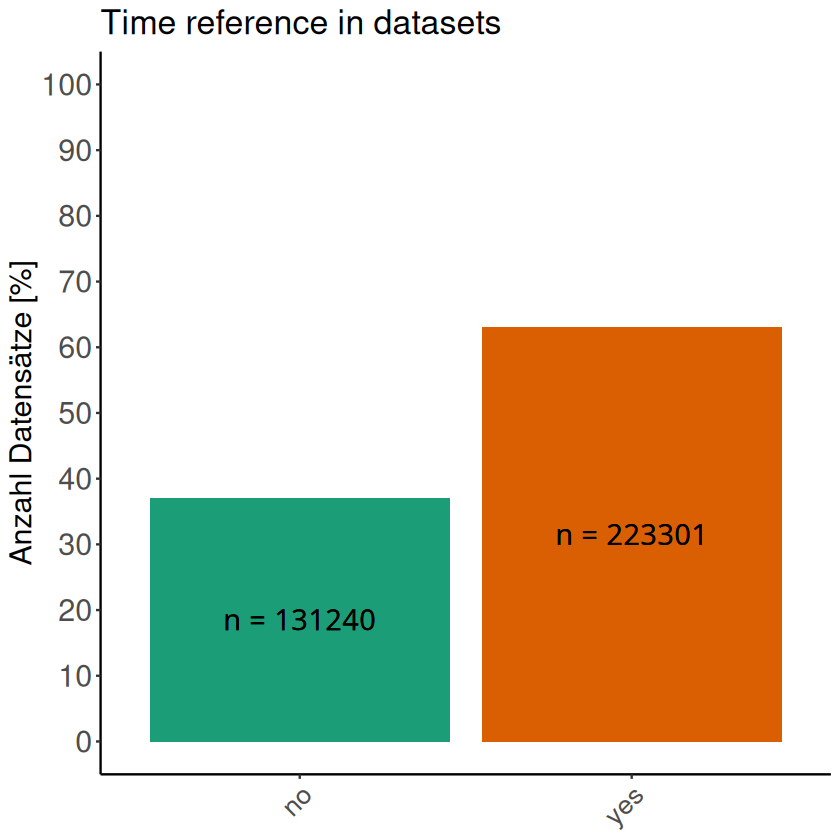

In [25]:
df.group %>% 
  group_by(time_reference) %>% 
  count() %>% 
  rename(total_count = n) %>% 
  mutate(percent_time_ref = total_count/nrow(raw_data) * 100) %>% # percent of datasets with time reference
  {. ->> overview.l1.df} %>% 
  ggplot(aes(x = time_reference, y = percent_time_ref, fill = time_reference)) +
  ggtitle("Time reference in datasets") +
  geom_bar(stat = "identity") +
  geom_text(x=1, y=overview.l1.df$percent_time_ref[1]/2, label= paste0("n = ", overview.l1.df$total_count[1]), size=6, family="IBM Plex Sans") +
  geom_text(x=2, y=overview.l1.df$percent_time_ref[2]/2, label= paste0("n = ", overview.l1.df$total_count[2]), size=6, family="IBM Plex Sans") +
  scale_y_continuous(limits = c(0, 100), breaks = seq(0, 100, by = 10)) +
  theme_classic() +
  ylab("Anzahl Datensätze [%]") +
  theme(plot.title = element_text(size = 20),
        axis.title = element_text(size = 18),
        axis.title.x = element_blank(),
        axis.text = element_text(size = 18),
        axis.text.y = element_text(size = 18),
        axis.text.x = element_text(angle=45, vjust = 1, hjust = 1, size = 16),
        legend.position = "none") +
  scale_fill_manual(values = brewer.pal(n = 2, name = 'Dark2')) ->> l1.overview.plot

### ### ### ###
l1.overview.plot

### Next we divide time_reference and visualise the data in more detail.

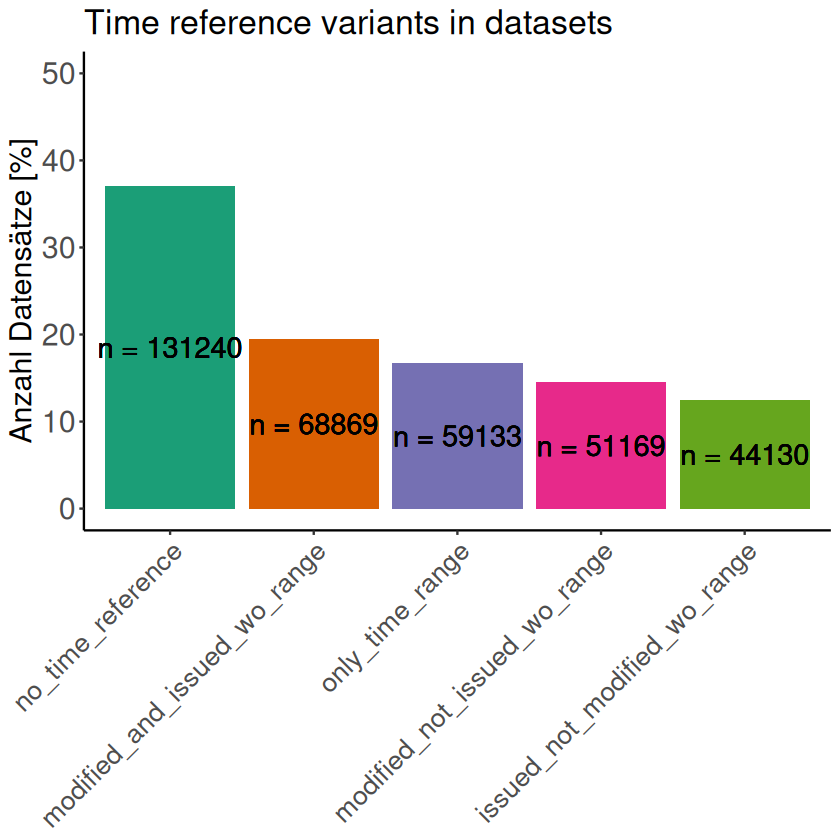

In [36]:
df.group %>% 
  group_by(type_time_ref) %>% 
  count() %>% 
  rename(total_count = n) %>% 
  mutate(percent_time_ref_type = total_count/nrow(raw_data) * 100) %>% # percent of datasets of each type of time reference
  arrange(desc(total_count)) %>% 
  mutate(type_time_ref = factor(
    type_time_ref, 
    levels = c(
      "no_time_reference",
      "modified_and_issued_wo_range",
      "only_time_range",
      "modified_not_issued_wo_range",
      "issued_not_modified_wo_range"))) %>% 
  {. ->> overview.l2.df} %>% 
  ggplot(aes(x = type_time_ref, y = percent_time_ref_type, fill = type_time_ref)) +
  ggtitle("Time reference variants in datasets") +
  geom_bar(stat = "identity") +
  geom_text(x=1, y=overview.l2.df$percent_time_ref_type[1]/2, label= paste0("n = ", overview.l2.df$total_count[1]), size=6) +
  geom_text(x=2, y=overview.l2.df$percent_time_ref_type[2]/2, label= paste0("n = ", overview.l2.df$total_count[2]), size=6) +
  geom_text(x=3, y=overview.l2.df$percent_time_ref_type[3]/2, label= paste0("n = ", overview.l2.df$total_count[3]), size=6) +
  geom_text(x=4, y=overview.l2.df$percent_time_ref_type[4]/2, label= paste0("n = ", overview.l2.df$total_count[4]), size=6) +
  geom_text(x=5, y=overview.l2.df$percent_time_ref_type[5]/2, label= paste0("n = ", overview.l2.df$total_count[5]), size=6) +
  scale_y_continuous(limits = c(0, 50), breaks = seq(0, 50, by = 10)) +
  theme_classic() +
  ylab("Anzahl Datensätze [%]") +
  theme(plot.title = element_text(size = 20),
        axis.title = element_text(size = 18),
        axis.title.x = element_blank(),
        axis.text = element_text(size = 18),
        axis.text.y = element_text(size = 18),
        axis.text.x = element_text(angle=45, vjust = 1, hjust = 1, size = 16),
        legend.position = "none") +
  scale_fill_manual(values = brewer.pal(n = 5, name = 'Dark2')) ->> l2.overview.plot
### ### ### ###
l2.overview.plot

## Visualise data grouped by source and whether there is a time reference or not

In [27]:
df.group %>% 
  ### ### ### ### group by source and time reference, count events by grouping-factor
  group_by(source, time_reference) %>% 
  count() %>% 
  rename(total_count = n) %>%  
  ungroup() %>% 
  ### ### ### ### count events per source and calculate percentage of events
  group_by(source) %>% 
  mutate(percent_time_ref_source = total_count/sum(total_count) * 100) %>% # percent of datasets with time reference for respective source
  ### ### ### ### apply filter 
  #  filter(str_detect(source, "ressourcen")) # filter for a particular source
  filter(!(time_reference == "time_reference" & percent_time_ref_source == 100)) %>%
  # filter(!(time_reference == "time_reference" & percent_time_ref_source >= 50)) %>%
  # filter((time_reference == "no_time_reference" & percent_time_ref_source == 100)) %>%
  arrange(source, total_count)

source                          time_reference total_count
1   aktion-flaeche-uba              no                12      
2   aktion-flaeche-uba              yes              211      
3   blauer-engel-uba                no               225      
4   daten-bw                        yes              138      
5   daten-und-fakten-bfn            no               129      
6   datenportal-be                  no                15      
7   diffuse-quellen-uba             yes                7      
8   doris-bfs                       no               577      
9   elwas-nrw                       no             24351      
10  elwas-nrw                       yes            35316      
11  elwis-gdws                      no               277      
12  elwis-gdws                      yes            27720      
13  endlagersuche-base              no                26      
14  endlagersuche-base              yes             5484      
15  energieatlas-st                 no                27      
16  ffh-vp-info-bfn                 no               570      
17  flora-web-bfn                   no             13458      
18  geodatenkatalog                 yes             4692      
19  geodatenkatalog-bfg             yes              235      
20  geomis-sn                       yes              257      
21  gewaesserberechnung-uba         no                 7      
22  gewaesserbewertung-uba          no               208      
23  giir-uba                        yes                6      
24  govdata                         no                 6      
25  govdata                         yes            26611      
26  greenpeace-daten                no                 9      
27  hochwasservorhersagezentrale-st no                 9      
28  hochwasservorhersagezentrale-st yes               57      
29  klivo-bmuv                      no               102      
30  klivo-bmuv                      yes              188      
⋮   ⋮                               ⋮              ⋮          
100 uvp-verbund-hh                  yes              115      
101 uvp-verbund-mv                  no                33      
102 uvp-verbund-mv                  yes              862      
103 uvp-verbund-ni                  no               613      
104 uvp-verbund-ni                  yes             2745      
105 uvp-verbund-nw                  no               198      
106 uvp-verbund-nw                  yes             2023      
107 uvp-verbund-rp                  no               166      
108 uvp-verbund-rp                  yes             1012      
109 uvp-verbund-sh                  no                33      
110 uvp-verbund-sh                  yes              557      
111 uvp-verbund-sl                  yes               38      
112 uvp-verbund-sl                  no                77      
113 uvp-verbund-sn                  no                60      
114 uvp-verbund-sn                  yes              648      
115 uvp-verbund-st                  no               258      
116 uvp-verbund-st                  yes              803      
117 uvp-verbund-th                  no                76      
118 uvp-verbund-th                  yes              435      
119 wasser-de-bfg                   no               201      
120 wasser-de-bfg                   yes              877      
121 wasserblick-bfg                 no               293      
122 wasserportal-be                 no              1145      
123 website-base                    no               262      
124 website-base                    yes            10648      
125 website-bfs                     no               134      
126 website-bfs                     yes             1631      
127 website-uba                     no                57      
128 website-uba                     yes             2023      
129 wisia-bfn                       no             26612      
    percent_time_ref_source
1     5.38116592           
2    94.61883408           
3   100.000000

Warning message in brewer.pal(n = 2, name = "Dark2"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


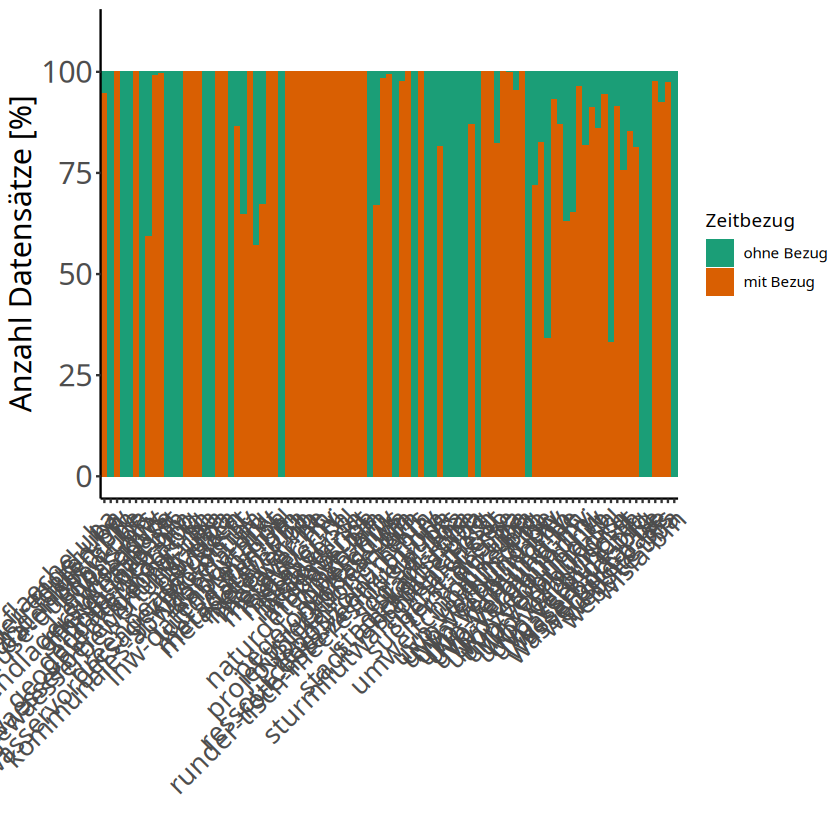

In [28]:
# achsen evtl. invertieren

df.group %>% 
  ### ### ### ### group by source and time reference, count events by grouping-factor
  group_by(source, time_reference) %>% 
  count() %>% 
  rename(total_count = n) %>%  
  ungroup() %>% 
  ### ### ### ### count events per source and calculate percentage of events
  group_by(source) %>% 
  mutate(percent_time_ref_source = total_count/sum(total_count) * 100) %>% 
  ### ### ### ### apply filter 
  filter(!(time_reference == "time_reference" & percent_time_ref_source == 100)) %>%
  # filter(!(time_reference == "time_reference" & percent_time_ref_source >= 50)) %>%
  filter(!(time_reference == "no_time_reference" & percent_time_ref_source == 100)) %>%
  ### ### ### ### visualize the data
  ggplot(aes(x = source, y = percent_time_ref_source, fill = time_reference)) +
  geom_bar(position="stack", stat = "identity") +
  scale_y_continuous(limits = c(0, 110), breaks = seq(0, 110, by = 25)) +
  theme_classic() +
  ylab("Anzahl Datensätze [%]") +
  theme(text = element_text(family="IBM Plex Sans"),
        plot.title = element_text(size = 20),
        axis.title = element_text(size = 18),
        axis.title.x = element_blank(),
        axis.text = element_text(size = 18),
        axis.text.y = element_text(size = 18),
        axis.text.x = element_text(angle=45, vjust = 1, hjust = 1, size = 16)
        ) +
  scale_fill_manual("Zeitbezug", 
                    values = brewer.pal(n = 2, name = 'Dark2'),
                    labels = c('ohne Bezug', 'mit Bezug')) ->> source.overview.plot 
### ### ### ###
source.overview.plot

### Combine the generated plots

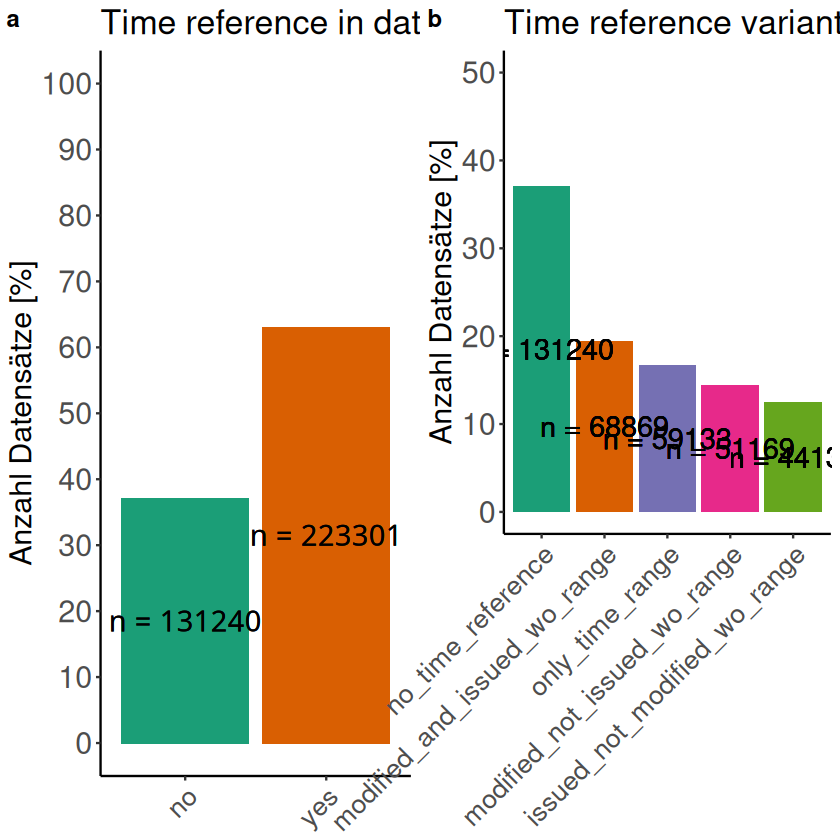

In [29]:
plot_grid(l1.overview.plot, l2.overview.plot, labels = c("a", "b"), scale = 1)

In [32]:
raw_data %>% select(source) %>% unique()


source                  
1      metaver-he              
41     nmzb-bfn                
51     uvp-verbund-th          
52     uvp-verbund-mv          
53     thru-de-uba             
947    projektsteckbriefe-bfn  
2469   energieatlas-st         
2583   daten-bw                
2697   govdata                 
2934   klivo-bmuv              
3876   geomis-sn               
4241   uvp-verbund-hh          
4371   rekis                   
4649   uvp-verbund-bb          
4996   elwis-gdws              
7194   endlagersuche-base      
8264   naturdetektive-bfn      
9399   metaver-sn              
11876  undine-bfg              
12265  metaver-st              
13231  umweltchronik-uba       
17678  ffh-vp-info-bfn         
18800  korina-ufu              
19398  daten-und-fakten-bfn    
19688  giir-uba                
19697  metaver-mv              
20924  geodatenkatalog-bfg     
21428  sdg-12-uba              
21761  pegelonline-gdws        
22855  metadaten-uba           
⋮      ⋮                       
80018  uvp-verbund-sn          
82612  website-uba             
85085  wasserblick-bfg         
85602  lhw-datenportal-st      
85792  website-bfs             
88608  uvp-verbund-st          
90067  stadt-karlsruhe         
90116  uvp-verbund-he          
90928  repositorium-bfn        
92148  lanuv-nrw               
93745  ressourceneffizienz-bmuv
94303  uvp-verbund-by          
95821  mudab-uba               
99527  uvp-verbund-sl          
99758  greenpeace-daten        
99776  flora-web-bfn           
109539 elwas-nrw               
110137 stadt-land-plus-uba     
111693 wasser-de-bfg           
113788 suche-st                
114039 sturmflutwarndienst-bsh 
114138 uvp-verbund-hb          
114366 uip-uba                 
114757 metaver-sl              
126587 metaver-hb              
127502 datenportal-be          
127526 metaver-bb              
128414 kommunales-abwasser-uba 
143724 publikationen-bfn       
145453 open-nrw

In [34]:
df.group %>% select(source, time_reference, modified, issued, time_ranges, source_url) %>% filter(str_detect(source, "govdata")) #%>% count() 

source  time_reference modified   issued     time_ranges
1     govdata yes            2024-03-02 2024-03-02 TRUE       
2     govdata yes            2024-03-02 2024-03-02 TRUE       
3     govdata yes            2024-02-29 2023-08-31 TRUE       
4     govdata yes            2024-03-02 2024-03-02 TRUE       
5     govdata yes            2024-01-12 2019-04-30 TRUE       
6     govdata yes            2023-09-27 2021-05-31 TRUE       
7     govdata yes            2023-02-23 2023-02-08 TRUE       
8     govdata yes            2024-03-02 2024-03-02 TRUE       
9     govdata yes            2022-12-08 2022-12-08 TRUE       
10    govdata yes            2017-01-27 2014-09-25 TRUE       
11    govdata yes            2021-04-23 2021-04-23 TRUE       
12    govdata yes            2024-03-02 2024-03-02 TRUE       
13    govdata yes            2024-03-02 2024-03-02 TRUE       
14    govdata yes            2024-03-02 2024-03-02 TRUE       
15    govdata yes            2024-03-02 2024-03-02 TRUE       
16    govdata yes            2020-02-24 2020-02-24 TRUE       
17    govdata yes            2024-03-02 2024-03-02 TRUE       
18    govdata yes            2023-08-21 2023-08-21 TRUE       
19    govdata yes            2023-02-23 2023-02-08 TRUE       
20    govdata yes            2024-03-02 2024-03-02 TRUE       
21    govdata yes            2023-11-10 NA         TRUE       
22    govdata yes            2024-03-02 2024-03-02 TRUE       
23    govdata yes            2023-06-24 2023-06-24 TRUE       
24    govdata yes            2024-03-03 2022-04-05 TRUE       
25    govdata yes            2024-03-02 2024-03-02 TRUE       
26    govdata yes            2022-04-29 2022-01-20 TRUE       
27    govdata yes            2022-10-13 2019-03-05 TRUE       
28    govdata yes            2024-03-02 2024-03-02 TRUE       
29    govdata yes            2024-03-02 2024-03-02 TRUE       
30    govdata yes            2024-03-02 2024-03-02 TRUE       
⋮     ⋮       ⋮              ⋮          ⋮          ⋮          
26588 govdata yes            2022-12-08 2022-12-08 TRUE       
26589 govdata yes            2023-02-23 2022-01-20 TRUE       
26590 govdata yes            2017-01-27 2016-10-26 TRUE       
26591 govdata yes            2024-03-02 2024-03-02 TRUE       
26592 govdata yes            2024-03-02 2024-03-02 TRUE       
26593 govdata yes            2022-10-26 2020-11-25 TRUE       
26594 govdata yes            2024-03-02 2024-03-02 TRUE       
26595 govdata yes            2024-03-02 2024-03-02 TRUE       
26596 govdata yes            2021-08-16 2021-05-12 TRUE       
26597 govdata yes            2024-03-02 2024-03-02 TRUE       
26598 govdata yes            2023-03-28 2019-11-11 TRUE       
26599 govdata yes            2023-08-06 2022-01-20 TRUE       
26600 govdata yes            2024-03-02 2024-03-02 TRUE       
26601 govdata yes            2017-01-27 2014-11-20 TRUE       
26602 govdata yes            2019-03-12 2019-03-12 TRUE       
26603 govdata yes            2024-03-02 2024-03-02 TRUE       
26604 govdata yes            2024-02-14 2024-02-14 TRUE       
26605 govdata yes            2024-03-02 2024-03-02 TRUE       
26606 govdata yes            2024-03-02 2024-03-02 TRUE       
26607 govdata yes            2022-12-22 2022-06-07 TRUE       
26608 govdata yes            2024-03-02 2024-03-02 TRUE       
26609 govdata yes            2024-03-02 2024-03-02 TRUE       
26610 govdata yes            2017-01-27 2014-09-25 TRUE       
26611 govdata yes            2024-02-23 2019-09-01 TRUE       
26612 govdata yes            2024-03-02 2024-03-02 TRUE       
26613 govdata yes            2022-01-25 2008-11-13 TRUE       
26614 govdata yes            2023-04-19 2019-11-11 TRUE       
26615 govdata yes            2017-01-27 2015-01-06 TRUE       
26616 govdata yes            2024-03-02 2024-03-02 TRUE       
26617 govdata yes            2021-06-01 2020-01-06 TRUE       
      source_url                                                                                    